In [1]:
import numpy as np
import pandas as pd
import os
import datetime

# for plotting
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sn

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# model modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats

### 1. Exploratory analysis

In [2]:
def load_data(filename):
    """
    It loads the data from the csv file to a pandas Dataframe.
    :param filename: str
    :return: pandas Dataframe
    """
    parent_dir = os.getcwd()
    df = pd.read_csv(os.path.join(parent_dir, filename))

    return df

In [3]:
filename_tv_spots = 'spots.csv'
filename_traffic = 'traffic.csv'

# load datasets
df_tv = load_data(filename=filename_tv_spots)
df_traffic = load_data(filename=filename_traffic)

In [4]:
# columns and their data type of df_tv dataframe;
# 864 datetimes with no missing values
df_tv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 1 columns):
agency_spot_time    864 non-null object
dtypes: object(1)
memory usage: 6.9+ KB


In [5]:
# visualise the dataset
df_tv.head()

,agency_spot_time
0,07.02.15 09:43
1,07.02.15 10:27
2,07.02.15 11:10
3,07.02.15 12:30
4,07.02.15 13:01


In [6]:
# columns and their data type of df_traffic dataframe;
# 416264 datetimes with no missing values
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416264 entries, 0 to 416263
Data columns (total 2 columns):
index    416264 non-null object
total    416264 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [7]:
# visualise the dataset
df_traffic.head()

,index,total
0,2015-01-01 00:05:30,1
1,2015-01-01 00:22:19,1
2,2015-01-01 00:33:32,1
3,2015-01-01 01:30:48,1
4,2015-01-01 01:48:18,1


In [8]:
# now let's parse the dates for tv and traffic data, 
# currently cast as objects, into datetime format
df_traffic['index'] = pd.to_datetime(df_traffic['index'].str.strip()
                                     , format='%Y-%m-%d %H:%M:%S')
df_tv['agency_spot_time'] = pd.to_datetime(df_tv.agency_spot_time.astype(str).str.strip()
                                           , format='%d.%m.%y %H:%M')

In [9]:
# set the index column as index of the dataframe df_traffic 
df_traffic.set_index('index', inplace=True)
# sorting datetimes in ascending oder
df_traffic.sort_index(inplace=True)

# set the agency_spot_time column as index of the dataframe df_tv
df_tv.set_index('agency_spot_time', inplace=True)
# sorting datetimes in ascending oder
df_tv.sort_index(inplace=True)

Information about the maximal and minimal datetime in the dataframe both for tv spots info
and traffic

In [10]:
print('Minimal datetime {} and maximal datetime {} of tv aired spots'
      .format(df_tv.index.min(), df_tv.index.max()))
print('Minimal datetime {} and maximal datetime {} in the traffic data'
      .format(df_traffic.index.min(), df_traffic.index.max()))

Minimal datetime 2015-02-07 09:43:00 and maximal datetime 2015-04-14 23:08:00 of tv aired spots
Minimal datetime 2015-01-01 00:05:30 and maximal datetime 2015-06-30 23:36:56 in the traffic data


In [11]:
# aggreagate the sum of impressions on the website by minute
agg_1m = df_traffic.groupby(pd.Grouper(freq='1Min')).aggregate(np.sum)

In [12]:
# visualise the data aggreation by minute
agg_1m.head()

,total
index,
2015-01-01 00:05:00,1
2015-01-01 00:06:00,0
2015-01-01 00:07:00,0
2015-01-01 00:08:00,0
2015-01-01 00:09:00,0


In [13]:
# information about the distribution of impressions' sum in minute
agg_1m.total.describe()

count    260612.000000
mean          1.659801
std           2.695045
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max         140.000000
Name: total, dtype: float64

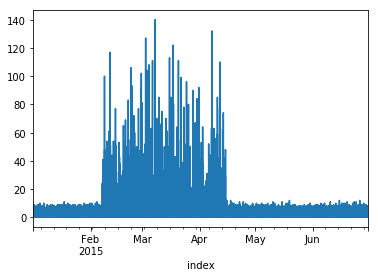

In [14]:
# plotting impressions' sum per minute
# We can see that for the time window of the tv campaign 
# (2015-02-07 09:43:00, 2015-04-14 23:08:00) 
# there is a significant increase of impressions.
agg_1m.total.plot()

In [15]:
# Later the dataframe of tv spots will be merge with the traffic data. 
# For that, the index of df_tv will have a floor of minutes
# but the tv spots' original timestamp with possible seconds is saved in the tv_spot column
df_tv['tv_spot'] = df_tv.index
df_tv.index = df_tv.index.floor('Min')

### 2. Impact of TV campaign on the traffic data

To quantify the impact of the TV splot on the traffic data, the observed traffic during the  TV spot airing must be compared with the natural traffic, which could have been seen without any TV spot. In this sense we need to define a baseline, which would respresent how the natural traffic would have looked like in absence of a TV spot. The visitors attributed to the spot itself are calculated as the difference between the generated traffic and the computed baseline.

There are many ways to define a baseline. A first approach defines the baseline as the linear interpolation between 20 minutes before and after the defined TV impact window. For this type of baseline, the temporarly airings of the consecutive tv spots shouldn't be close to each other. 

A second approach concerns the creation of a baseline, where the data before and after the time window of the tv campaign is considered to be modelled. Compared to the first approach, the second one makes sure that daytime, seasonal and other normal variations will be taken into account as trends in the model. 

In [16]:
# difference in minutes between consecitive tv_spots
df_tv['diff_mins'] = df_tv.tv_spot.diff().astype('timedelta64[m]')

In [17]:
df_tv['diff_mins'].describe()

count     863.000000
mean      111.060255
std       176.705789
min         0.000000
25%        20.000000
50%        48.000000
75%       108.500000
max      1003.000000
Name: diff_mins, dtype: float64

In [18]:
# the percentage of tv_spots aired within a time window of 20 minutes represents more the 20% 
# the total number of tv spots.
len(df_tv.loc[df_tv['diff_mins']<20])/len(df_tv)

0.24537037037037038

For this reason, the second approach to model the baseline will be implemented. New features are created which could explain the organic fluctuations of the visits:
1. seasonality component
2. day of the week
3. hour of the day
4. weekend

In [19]:
# numerical encoding for month
agg_1m['month'] = agg_1m.index.month

In [20]:
# numerical encoding for season
agg_1m['season'] = agg_1m.month.apply(lambda x: (x%12 + 3)//3)

In [21]:
# since the data are for only few months and only from one year, 
# this feature is unnecessary for the impressions' prediction
agg_1m.drop(columns='month', inplace=True)

In [22]:
# # numerical encoding for the day within a week
# Monday = 0, Tuesday = 1, Wednesday= 2, Thursday = 3, Friday = 4,
# Saturday = 5, Sunday is 6.
agg_1m['weekday'] = agg_1m.index.weekday

In [23]:
# increasing numerical encoding for day hour
agg_1m['hour'] = agg_1m.index.hour

In [24]:
# binary weekend feature (weekend includes Saturday and Sunday)
agg_1m['is_weekend'] = 0
agg_1m.loc[(agg_1m['weekday'] == 5) |
             (agg_1m['weekday'] == 6), 'is_weekend'] = 1

In [25]:
# extraction of the start and end date of the tv campaign
min_tv = df_tv.index.min()
max_tv = df_tv.index.max()

# traffic data where data from the tv campaign is excluded
mask = (agg_1m.index < min_tv) | (agg_1m.index > max_tv)
agg_1m_not_tv = agg_1m.loc[mask]

# traffic data only from the tv campaign is selected
mask_tv = (agg_1m.index >= min_tv) & (agg_1m.index <= max_tv)
agg_1m_tv = agg_1m.loc[mask_tv]

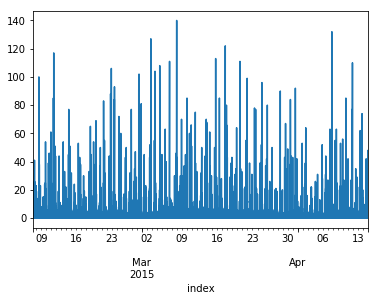

In [26]:
agg_1m_tv.total.plot()

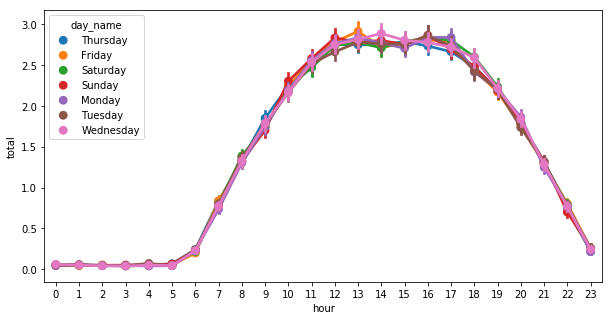

In [27]:
# visualization of visitors at the leisure attraction
# for month and day of the week
agg_1m_not_tv['day_name'] = agg_1m_not_tv.index.day_name()
fig, ax = plt.subplots(figsize=(10,5))
sn.pointplot(data=agg_1m_not_tv[['day_name', 'total', 'hour']],
            x='hour', y='total',
            hue='day_name', ax=ax)
agg_1m_not_tv.drop(columns=['day_name'], inplace=True)

Although a pattern of impressions can be indentified through the day hours, this pattern is really similar accross days of the week.

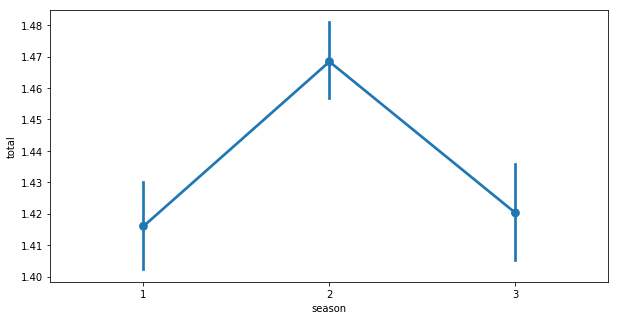

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sn.pointplot(data=agg_1m_not_tv[['total', 'season']],
            x='season', y='total', ax=ax)

The different three seasons are displayed and only a slight increase in the visits can be seen in the months of April, May and June.

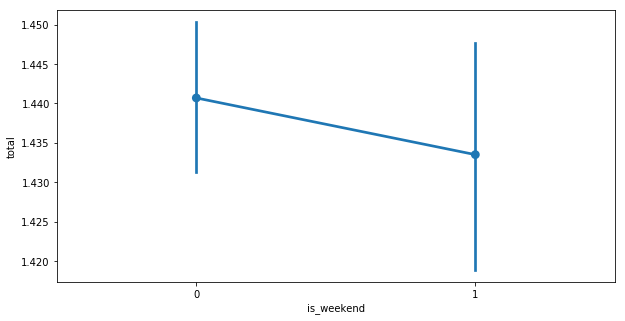

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sn.pointplot(data=agg_1m_not_tv[['total', 'is_weekend']],
            x='is_weekend', y='total', ax=ax)

The binary feature for weekend is displayed, which a slight decrease in visits can be seen for the weekend compared to the rest of the week. We have to admit that the visits show high variance, especially for the weekend.

Based on the information about the season (seasonality), weekend, week day and day hour, the number of visits can be predicted. Linear models are not recommended for this problem because of assumptions that can't be met. Instead tree-based methods don't have any particular assumption, and in particular gradient-boosted trees,  which generally perform better than a random forest or extra randomized trees.

In [30]:
def train_test_km(df, target_var, test_size):
    """
    The dataset is split in training and test data based on the test_size
    The Kolmogorov-Smirnov statistics is executed to verify weather the feature
    distributions between train and test are significantly dissimilar.
    :param df: pandas Dataframe
    :param test_size: float
    :return: numpy array, numpy array, numpy array, numpy array
    """
    Y = df[target_var].values
    df_ = df.drop(columns=target_var)
    X = df_.values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
                                                        random_state=0)
    # Kolmogorov-Smirnov statistics
    # to check whether the data come from the same distribution
    xtrain = pd.DataFrame(X_train, columns=df_.columns)
    xtest = pd.DataFrame(X_test, columns=df_.columns)
    for col in df_:
        _, pvalue = stats.ks_2samp(xtrain[col], xtest[col])
        if pvalue < 0.05:
            print("For the feature {}, the distributions of train and test"
                  "samples are significantly dissimilar with a p-value of {}."
                  .format(col, str(pvalue)))

    return X_train, X_test, y_train, y_test

In [31]:
# splitting the data in train and test sets
X_train, X_test, y_train, y_test = \
    train_test_km(df=agg_1m_not_tv, target_var="total", test_size=0.20)

In [32]:
# modelling with gradient boosting regressor
model = GradientBoostingRegressor(n_estimators=1000, random_state=0)
model.fit(X_train, y_train)

# predictions on the test set
predictions = model.predict(X_test)
# the root of the squared mean error is chosen as evaluation metric
print('RMSE = {}'.format(str(np.sqrt(mean_squared_error(y_test, predictions)))))

RMSE = 1.1983676260425682


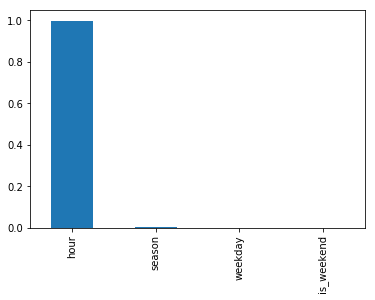

In [33]:
# the importance of the variables is displayed and it is visible 
# that the hour is the most and only feature explaining the visits
important_features = pd.Series(data=model.feature_importances_,
                               index=agg_1m_not_tv.drop(columns='total').columns.values)
important_features.sort_values(ascending=False, inplace=True)
important_features.plot(kind='bar')

In [34]:
# based on the features created the model predictions are applied on the data 
# from the time window of the tv campaign
agg_1m_tv['baseline'] = model.predict(agg_1m_tv.drop(columns=['total']))

In [35]:
# the users attributed to the tv spots are calculated 
# by the difference between total visits and baseline predicted visits 
agg_1m_tv['attributed_traffic'] = agg_1m_tv.total-agg_1m_tv.baseline

In [36]:
# traffic data is merged with the tv spots dataframe
attr_df = agg_1m_tv.merge(df_tv[['tv_spot']],
                                 left_index=True, right_index=True, how='left')

In [37]:
# selection and rename of some columns
attribution_df = attr_df[['total', 'attributed_traffic', 'tv_spot']]

In [38]:
attribution_df.rename(columns={'total':'total_traffic'}, inplace=True)

In [39]:
attribution_df.head()

,total_traffic,attributed_traffic,tv_spot
2015-02-07 09:43:00,17,15.225938,2015-02-07 09:43:00
2015-02-07 09:44:00,24,22.225938,NaT
2015-02-07 09:45:00,6,4.225938,NaT
2015-02-07 09:46:00,3,1.225938,NaT
2015-02-07 09:47:00,1,-0.774062,NaT


Although the start of the tv-induced uplift can be represented by the airing of the tv spot, its end is defined by two factors:

1. The natural and dynamic end of an tv-induced uplift it is defined when the attributed visits are equal to zero or show a negative value, meaning that the predicted visits are higher than the actual visits. 
2. If the natural end is not found within 20 minutes after the airing of the tv spot, an artificial end is given to tv-induced uplift.

In [40]:
# Converting the index as date
attribution_df.index = pd.to_datetime(attribution_df.index)

def define_start_end_tv_uplift(data, col_tv_spot, col_attrib_visits, duration):
    """
    It iterates through all the tv spot datatimes and for each one the attributed visits'
    values which are equal or below zero are selected. If the selected dataframe is empty,
    an artifical end is given to the tv-induced uplift with a duration 
    given by the function paramenter.Otherwise the earliest datetime 
    is chosed as natural end of the tv-induced uplift.
    :param data: Dataframe
    :param col_tv_spot: string
    :param col_attrib_visits: string
    :param duration: integer
    return Dataframe
    """
    # new column is created
    data['tv_spot_uplift'] = None
    for tv_spot in data[col_tv_spot].dropna().tolist():
        start_uplift = tv_spot
        # definition of the artificial end
        artificial_end_tv_spot = start_uplift + datetime.timedelta(minutes=duration)
        #  selected all the data point which are greater than the uplift start,
        #  which are before the arificial end and whose value for the attributed visits is 
        #  equal or below zero.
        temp_mask = (data.index >= start_uplift) & (data.index <= artificial_end_tv_spot) & (data[col_attrib_visits] <= 0)
        temp_df = data[temp_mask]
        
        #  if the selected dataframe is not empty,
        #  the earliest index is chosen as the natural end, otherwise the artificial end.       
        if len(temp_df)>0:
            end_uplift = temp_df.index.min()
        else:
            end_uplift = artificial_end_tv_spot
        # in the new column the uplift start is repeated for all the datapoints which belong 
        # to the time window of tv-induced uplift        
        data.loc[(data.index >= start_uplift) 
                           & (data.index < end_uplift), 
                           'tv_spot_uplift'] = start_uplift
    # the old column with tv_spot information is dropped from the dataframe
    data.drop(columns=col_tv_spot, inplace=True)
        
    return data


In [41]:
# definition of the start and end of an tv-induced uplift
attribution_df = define_start_end_tv_uplift(data=attribution_df, col_tv_spot='tv_spot', 
                               col_attrib_visits='attributed_traffic', duration=20)

In [42]:
save_df = attribution_df.reset_index()
save_df.rename(columns={'index': 'timestamp'}, inplace=True)

I saved the dataset with also an additional column (tv_spot_uplift) where the tv_spot timestamp is repeated for the time window of the found tv-induced uplift.

In [43]:
save_df.to_csv("tv_attribution.csv", index=False)

### 3. Plotting time series: 

Below a random day included in the tv campaign is shown: on the x-axis the hours are displayed, whereas on the y-axis the count of visits can be seen. The blu line represents the actual visits; the orange line instead represents the baseline predicted values for that hour.
The dashed vertical red lines represent instead the airings of different tv spots.

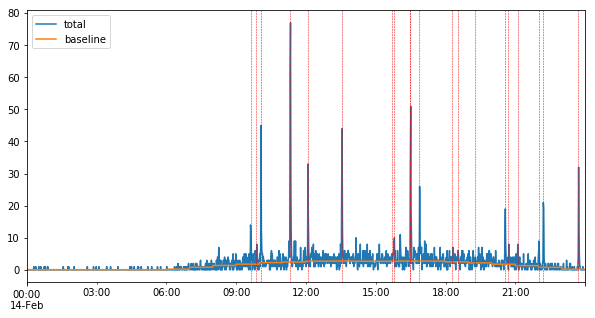

In [44]:
example_day = attr_df.loc[attr_df.index.date == datetime.date(2015, 2, 14)]
example_day[['total', 'baseline']].plot(figsize=(10,5))
for tv_spot in example_day.tv_spot.dropna().tolist():
    plt.axvline(tv_spot, color='r', linestyle='--', lw=0.5)

### 4. Improvements if I had more time 

1. Improvements for the implemented model: 
    - cross validation to the training set
    - variable selection methods, since we see that only hour represents the predictive variable for the website visits
    - model selection: I have chosen gradient boosting which is known to performs better than other tree-based models, but a comparision accross them would be recommended
    - the root of the mean suared error is pretty high: this can be do to high bias (the model is not complex enough) or high variance (overfitting on the traning data and poor performance on the test data) or both. I would check for that comparing the error on the training and test set and based on the outcome I would amke the adjustments.


2. Choice of the model: Structural time series models are recommended for time series forecasting : they are set up as a regression model in which the variables are in function of time, but their coeffiecients can change over time. The flexibility of letting the regression coefficients change over time is not provided by the model implemented in this task.


3. The implemented calculation of the attributed visits does not take into account the case of overlapping tv spots. To account for that, attributed visits can be weighted for the the reach of the tv spot.